## Paper Reading:Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks

### Application
3D object detection, part-based detection, instance segentation, image captioning.

### Previous Problem
- Region proposal method previously relies on `Selective Search`, even though combined with `EdgeBoxes`, the computational efficiency is still low.

### Model Architecture ≈RPN+Detector 
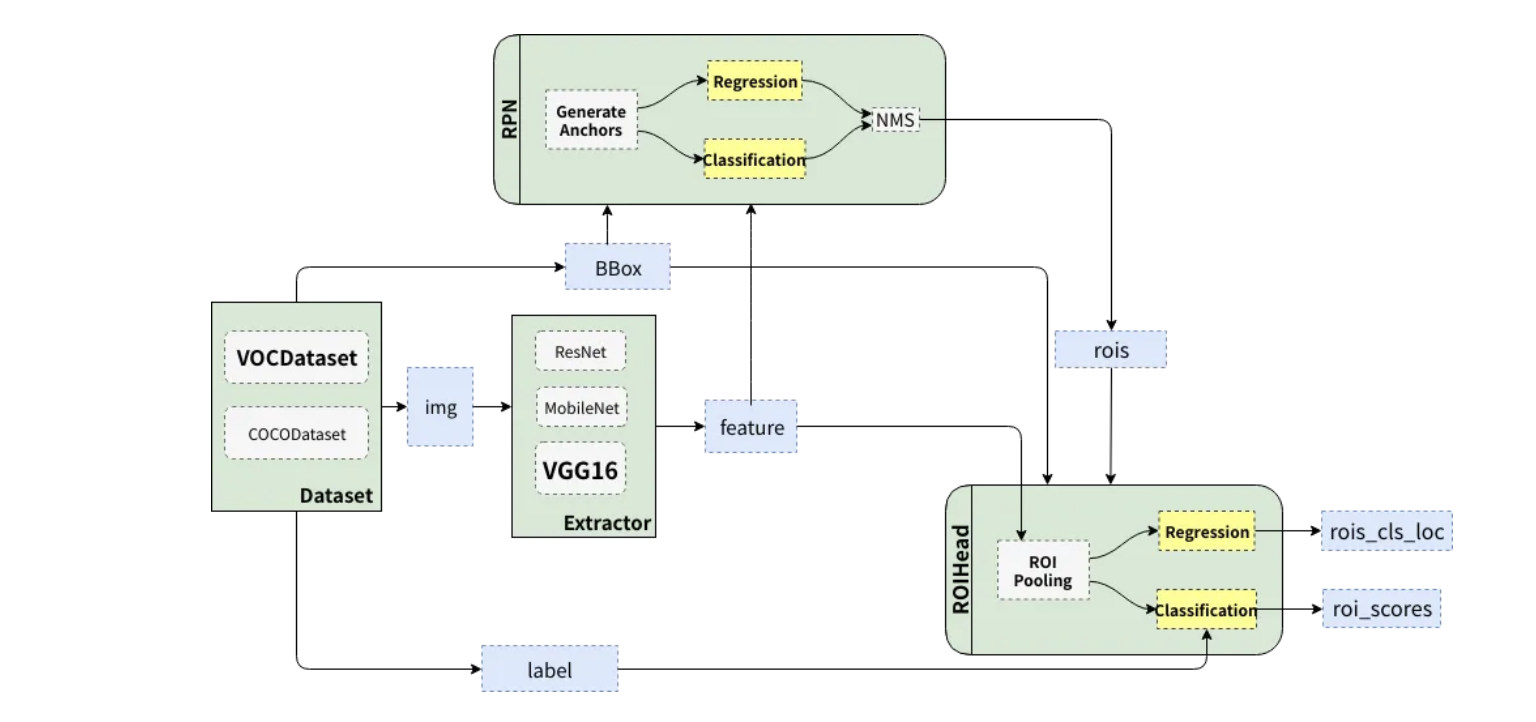

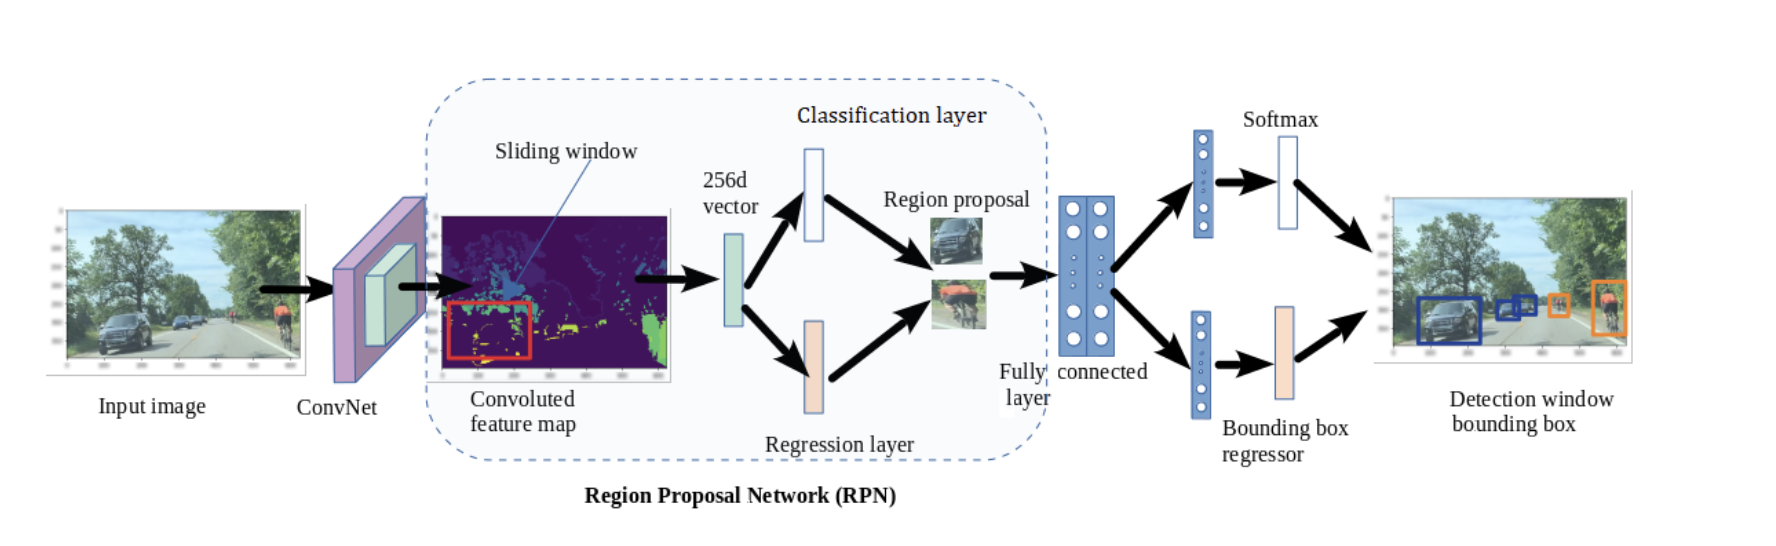

#### Region Proposal Network(RPN)--'Attention' mechanisms
- **Share the convolutional layers network** at testing time, the computational cost is small.
- <u>Replace Selective Search</u> method used in Fast RCNN
- **Input**:images with any size;
- **Output**: rectangular object proposals with <u>objectness score</u>.(21500 in total)
- **pyramid of regression reference(anchor)**, avoiding listing images or filters of <u>multiple scales or aspect ratios</u>, sharing features without extra costs.
- set a `sliding window` (size=**3x3** in this paper) over the feature map output by the last shared conv layer.
- Each sliding window is mapped to a lower-dimensional feature, which is fed into 2 fully-connected layers(both size=1x1)
   - Box-regression layer（*reg*)
   - Box-classification layer(*cls*)
- Outputs:
   - reg layers:4k output encoding the coordinates of k boxes.
   - cls layers: 2k scores of probabilities
##### Anchor
- <strong>$k$</strong>: maximum numbers of predicted possible proposals for each sliding-window location.
- **Defintion**: centered in sliding window, k proposals parameterized relative to k reference boxes
- **Numbers of anchor calculation**:
   - =numbers of scales*numbers of aspect ratios
   - if the feature map size=$W*H$, then numbers of anchor=$W* H*k$
- **Size**: 128,256,512 pixels with width/height=1:1 or 1:2 or 2:1.
- **Translation-Invariant Anchor**
   - Defintion: guarantee the same proposal is generated and the same function is able to predict the propsoal if an object is translated.
   - Effects: reduce the model size and has less risk of overfitting on small datasets
##### Loss Function
- Objective Function is to assign a binary class, whether being an object or not, to each anchor.
   - Positive label: highest IoU or IoU>0.7
   - Negative label: IoU < 0.3
   - The remaining anchors without any labels: not contribute to training objective.
- Loss Function:
$L(\lbrace p_i\rbrace,\lbrace t_i \rbrace)=\frac{1}{N_{cls}}∑_iL_{cls}(p_i,p_i^*)+λ\frac{1}{N_{reg}}∑_ip^*L_{reg}(t_i,t_i^*)$
- Notation:
   - $i$: index of anchor
   - $p_i$: probability of achor $i$ being an object
   - $p_i^*$: ground-truth label, if=1, the anchor is positive; if=0, negative.
   - $t_i$: coordinates of predicted bounding box for anchor $i$,with $(x,y,w,h)$
   - $t_i^*$: true box coordinates with positive anchor
   - $N_{cls}$: numbers of anchor in mini-batch
   - $N_{reg}$: numbers of anchor locations
   - $L_{cls}$: log loss
   - $L_{reg}$: with smooth $L1$ loss
   - By default, we set $λ$ the balancing parameter$=10$

For bounding box regression coordinates parameterization:
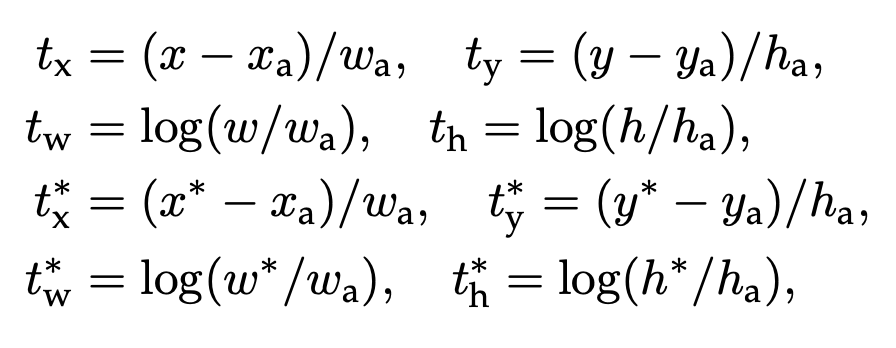

##### Training
- SGD with back-propagation
- mini-batch size=256 
- image-centic sampling strategy, sampled positive:negative anchor=1:1. If $< 128$ anchors are positive→treat this mini-batch with negative ones.
- Weight initalization: ~Gaussian Distribution(𝝁=0.0,σ=0.01)
- For shared conv layers in CNN we use VGG network
   - momentum=0.9
   - weight decay=0.0005
   - learning rate=0.001 or 0.0001
- Total training time=150hrs, testing time=0.2secs, mAP=66.9% with VOC2007.

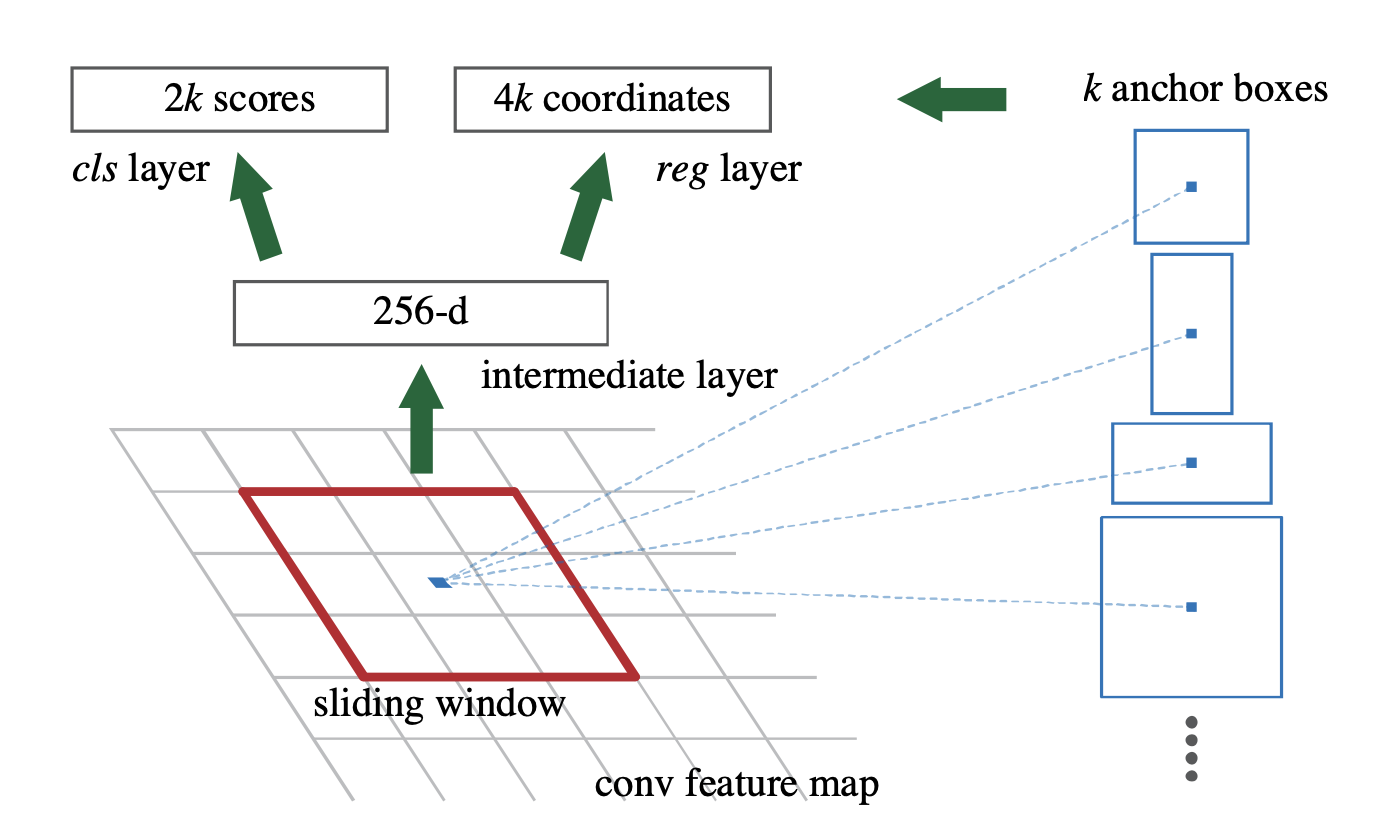

### Freature Sharing between RPN and Detector
- Detector we use `Fast RCNN`
- 4 steps:
   1. Train the RPN
   2. Train detection network using proposals generated from step1, *without sharing* any conv layers
   3. Use detector network to initalize RPN training, both networks share conv layers
   4. Fine-tune the unique layers of Fast RCNN

### CNN Architecture: VGG16(or ResNet)
- VGG16 is used in original paper which is similar to Fast RCNN, sometimes ResNet model is applied in Faster RCNN as well.
- For VGG16, it has 13 shareable conv layers


#### ResNet Architecture
- deep network with 152 layers, easliy causing problem of vanishing or exploding gradient, which can be addressed by:
  - normalized initialization
  - normalization layer
  - SGD with backpropagation
- <strong>Residual Learning</strong>:address the accuracy degradation problem
  - Degradation problem: the accuracy of deep networks degrading when the number of layers become very high.
  - extra layers can just learn to perform an identity mapping, leading to the performance of deeper model equal to the shallower model
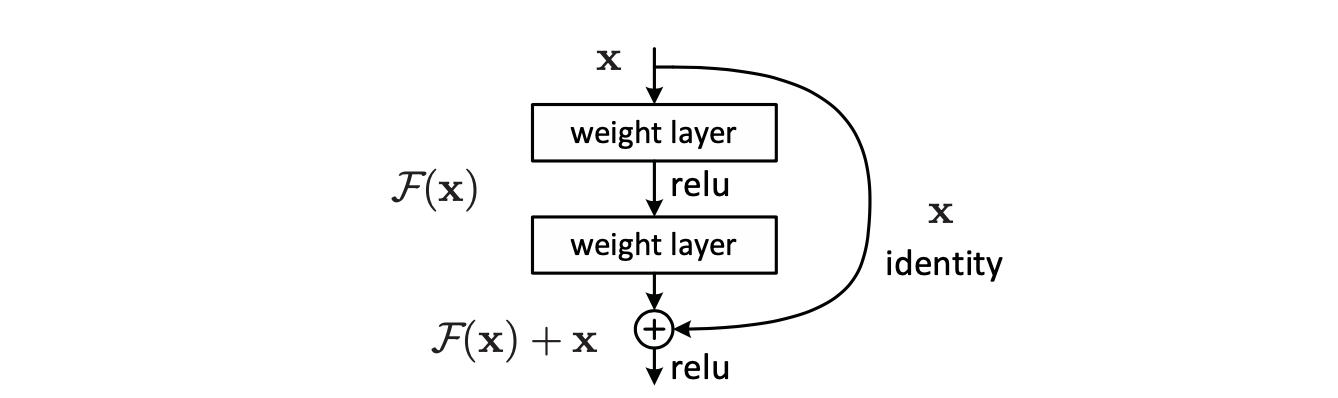

- Some layers fit the `residual mapping`. It is much *easier* to optimize the residual mapping than original.
  - Extreme case: if identity mapping is optimal, it is easier to push residual to 0.
  - Shortcut connection: skip >=1 layers, perform in indentity mapping.
     - without any extra parameters and computation complexity
- Notation:
  - $H(x)$: mapping process with stacked layers
  - $F(x)=H(x)-x$: residual function,stacked non-linear layers fit another mapping process
  - $F(x)+x$: original overall mapping
  - $y=F(x, \lbrace W_i \rbrace)+x$: a building block
    - $x$: input vector
    - $y$: output vector
- If the added layers be constructed as <u>identity mappings</u>, the training error of degradation problem will be eased.

##### Identity Mapping
- $F(x,\lbrace W_i \rbrace)$: residual mapping
- Linear projection $W_s$,a square matrix
   - Goal: the dimensions of $x$ and $F$ should be the same, linear projection helps to <u>match dimensions</u>.
   - Function: $y=F(x,\lbrace W_i \rbrace)+W_sx$

##### Plain Network
- Convolutional layers almost have <u>3*3 filters</u>
- for the same size of feature maps, the layers have the same numbers of filter
- if the feature map size is halved, the number of filters should be <u>doubled</u>, to keep the complexity of network.
- downsampling: stride=2
- output layer: global average pooling layer+fully connected layers+softmax

##### Residual Network
- add shortcut connections, which is directly used if output and input gain the same dimensions
- If the dimensions increases:
   - Option1: use `zero padding` for increasing dimensions
   - Option2: projection shortcut for increasing dimensions, remaining still use zero-padding
   - Option3: **all** shortcuts use `projection shortcut`.
- Effects Comparision: 3>2>1
   - However, option3 introduces the extra parameters. For reducing compitational complexity and memory storage, we do not use option3.

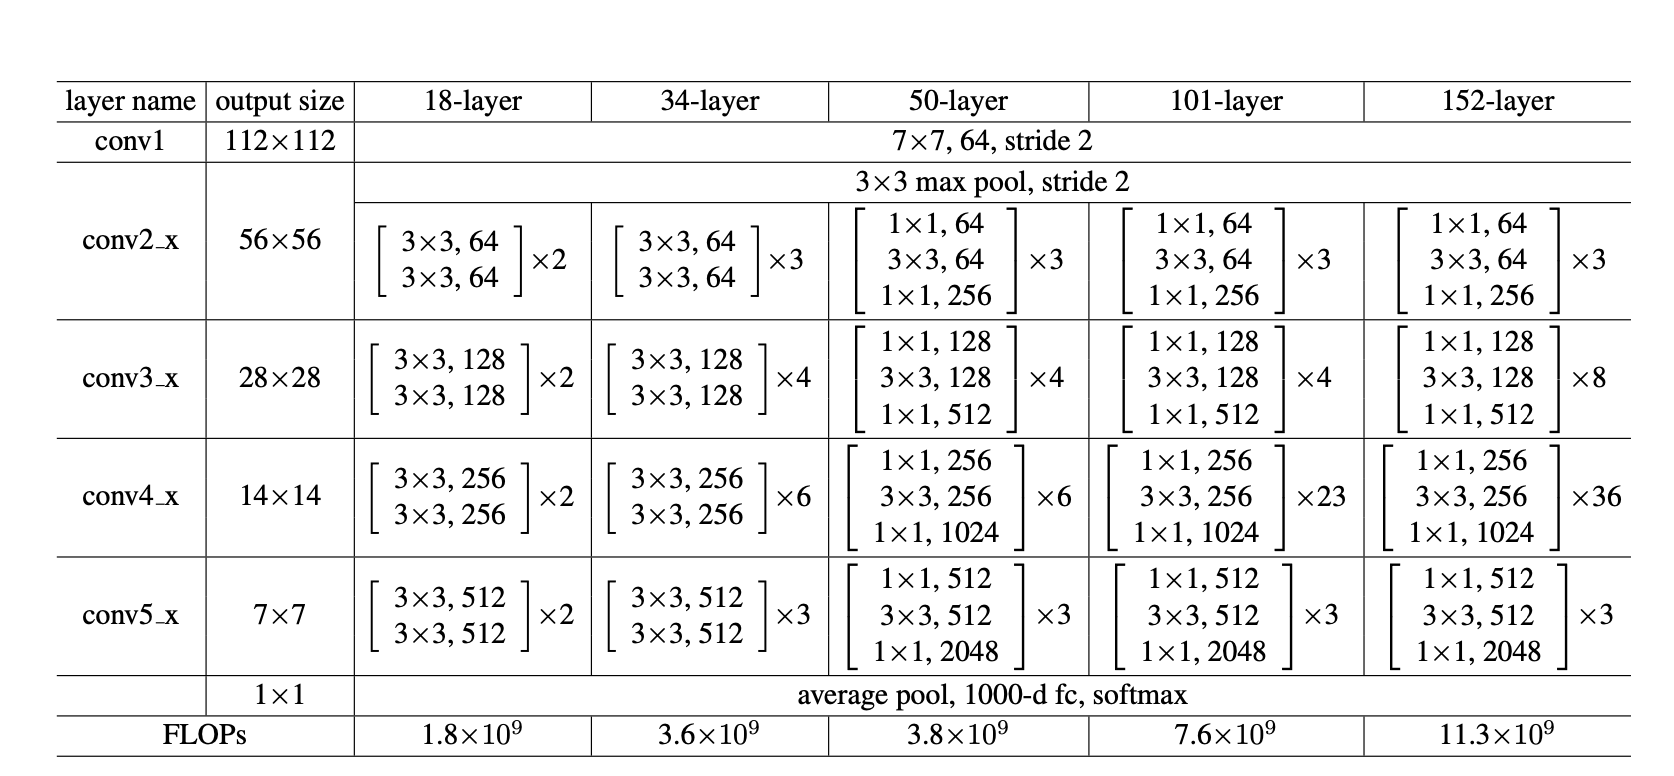

##### Different depth of layers(50/101/152)
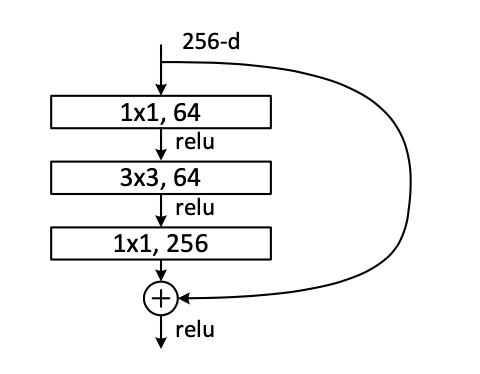
- Bottleneck design: use <strong>three</strong> stacked layers instead of 2, with 1x1,3x3,1x1 convolutions and <u>identity</u> shortcut.
- 152-layers ResNet complexity<< VGG16/19
- Accuracy of 50/101/152-layers ResNet>> accuracy of 34-layers ResNet
- Explore 1202-layers ResNet: without any optimization problem, it is able to achieve training error less than 0.1%
  - But the performance of 1202-layers< 110-layers, owing to **overfitting**.


#### Implementation
- Batch normalization after each convolution before activation function
- SGD mini-batch size=256
- learning rate=0.1
- Weight decay=0.0001
- momentum=0.9
- dropout=None

#### Coding: 
##### Method1: TensorFlow
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet152

In [9]:
import tensorflow as tf
tf.keras.applications.resnet.ResNet152(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

242900224/242900224 [==============================] - 2s 0us/step


In [20]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
 
base_model = ResNet50(include_top=False, weights='imagenet')
# Taking the output
x = base_model.output
 # Adding a Global Average Pooling layer
x = GlobalAveragePooling2D()(x)
 # Adding a fully connected layer having 1024 neurons
x = Dense(1024, activation='relu')(x)
# Adding a fully connected layer having 2 neurons which will give the probability of image classificatio
predictions = Dense(2, activation='softmax')(x)
 # Model to be trained
model = Model(inputs=base_model.input, outputs=predictions)
 # Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = False
# Compiling the model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


##### Method2: HuggingFace
- https://huggingface.co/microsoft/resnet-50
- https://huggingface.co/docs/transformers/main/en/model_doc/resnet#resnet


##### Method3

In [14]:
import torch
from torch import nn
import torch.nn.functional as F

In [16]:
class ShortCutProjection(nn.Module):
  def __init__(self, in_channels:int, out_channels:int, stride:int): 
    #in_channels:number of channels in x
    #out_channels:number of channels in F
    super().__init__() #use the parent function
    self.conv=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride)
    self.bn=nn.BatchNorm2d(out_channels)

  def forward(self, x:torch.Tensor):
    return self.bn(self.conv(x)) #convolution and batch normalization

In [17]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, stride: int):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.act1 = nn.ReLU()
    
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    # Shortcut connection should be a projection if the stride length is not 1 or if the channels get changed
    if stride != 1 or in_channels != out_channels:
      self.shortcut = ShortCutProjection(in_channels, out_channels, stride)
    else: #use indentity x
      self.shortcut = nn.Identity()
    self.act2 = nn.ReLU() #after adding shortcut

  def forward(self, x: torch.Tensor):
    #x with input shape: [batch_size, in_channels, height, width]
    shortcut = self.shortcut(x) #shortcut connection
    x = self.act1(self.bn1(self.conv1(x)))
    x = self.bn2(self.conv2(x))
    return self.act2(x + shortcut)

In [18]:
class BottleneckResidualBlock(nn.Module):
  def __init__(self, in_channels: int, bottleneck_channels: int, out_channels: int, stride: int):
    #bottleneck_channels: the number of channels for the 3 * 3 convolution
     super().__init__()
     #map to bottleneck_channels
     self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1)
     self.bn1 = nn.BatchNorm2d(bottleneck_channels)
     self.act1 = nn.ReLU()

     self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1)
     self.bn2 = nn.BatchNorm2d(bottleneck_channels)
     self.act2 = nn.ReLU()
     #maps to out_channels
     self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1)
     self.bn3 = nn.BatchNorm2d(out_channels)
     if stride != 1 or in_channels != out_channels:
       self.shortcut = ShortCutProjection(in_channels, out_channels, stride)
     else:
       self.shortcut = nn.Identity()
     self.act3 = nn.ReLU()
  def forward(self, x: torch.Tensor):
     shortcut = self.shortcut(x)
     x = self.act1(self.bn1(self.conv1(x))) #First convolution and activation
     x = self.act2(self.bn2(self.conv2(x))) #second convolution and activation
     x = self.bn3(self.conv3(x))
     return self.act3(x + shortcut)

In [19]:
from typing import List, Optional
class ResNetBase(nn.Module):
  def __init__(self, n_blocks: List[int], n_channels: List[int],bottlenecks: Optional[List[int]] = None,img_channels: int = 3, first_kernel_size: int = 7):
    #img_channels:the number of channels in the input.
    #first_kernel_size:the kernel size of the initial convolution layer
    super().__init__()
    #Number of blocks and number of channels for each feature map size
    assert len(n_blocks) == len(n_channels)
    assert bottlenecks is None or len(bottlenecks) == len(n_channels)
    self.conv = nn.Conv2d(img_channels, n_channels[0], kernel_size=first_kernel_size, stride=2, padding=first_kernel_size // 2)
    self.bn = nn.BatchNorm2d(n_channels[0])

    blocks = []
    prev_channels = n_channels[0] #Number of channels from previous layer
    for i, channels in enumerate(n_channels):
      stride = 2 if len(blocks) == 0 else 1
      if bottlenecks is None: #map from prev_channels to channels
        blocks.append(ResidualBlock(prev_channels, channels, stride=stride))
      else:#map from prev_channels to channels
        blocks.append(BottleneckResidualBlock(prev_channels, bottlenecks[i], channels,stride=stride))

      prev_channels = channels  # Change the number of channels
      #add rest of the blocks
      for _ in range(n_blocks[i] - 1):
        if bottlenecks is None:
          blocks.append(ResidualBlock(channels, channels, stride=1))
        else:
          blocks.append(BottleneckResidualBlock(channels, bottlenecks[i], channels, stride=1))
    self.blocks = nn.Sequential(*blocks) #stack the layers

  def forward(self, x: torch.Tensor):
    x = self.bn(self.conv(x))
    x = self.blocks(x) #residual blocks
    x = x.view(x.shape[0], x.shape[1], -1) #change shape to [batch_size, channels, h * w]
    return x.mean(dim=-1) #global average pooling

### Non-Maximum Suppression(NMS)



- Different variants: 
  - Oriented in Classification tasks: Standard NMS, Soft NMS
  - Location with center distance: DIoU NMS
  - Variance-weighted average: Softer NMS
  - Weighted Average: Weighted NMS
  - Others: Conv NMS, Yes-NMS
-We focus on <u>original NMS</u> in this case, with **IoU threshold=0.7**
- Function:
$s_i=\begin{cases}
s_i, iou(M,b_i)< N_i \\
0, iou(M,b_i) ≥ N_i
\end{cases}$
- Notation:
  - $s_i$: the score of each bounding box
  - $M$: the box with largest score
  - $b_i$: one of the remaining bounding box
  - $N_i$: threshold

In [4]:
import numpy as np
def computeIoU(box1, box2, wh=False): #wh: the format of coordinate. IoU: the relationship between box1 and box2
  if wh==False:
    xmin1,ymin1,xmax1,ymax1=box1
    xmin2,ymin2,xmax2,ymax2=box2
  else: #[xcenter,ycenter,w,h]
    xmin1, ymin1 = int(box1[0]-box1[2]/2.0), int(box1[1]-box1[3]/2.0)
    xmax1, ymax1 = int(box1[0]+box1[2]/2.0), int(box1[1]+box1[3]/2.0)
    xmin2, ymin2 = int(box2[0]-box2[2]/2.0), int(box2[1]-box2[3]/2.0)
    xmax2, ymax2 = int(box2[0]+box2[2]/2.0), int(box2[1]+box2[3]/2.0)
  #get the intersection coordinates
  xx1 = np.max([xmin1, xmin2])
  yy1 = np.max([ymin1, ymin2])
  xx2 = np.min([xmax1, xmax2])
  yy2 = np.min([ymax1, ymax2])
  #compute the areas of two boxes
  area1 = (xmax1-xmin1) * (ymax1-ymin1)
  area2 = (xmax2-xmin2) * (ymax2-ymin2)

  inter_area = (np.max([0,xx2-xx1])) * (np.max([0,yy2-yy1]))
  iou = inter_area/(area1+area2-inter_area+1e-6)
  return iou

For `Soft NMS`:
- Function:
$s_i=\begin{cases}
s_i, iou(M,b_i)< N_i \\
s_i(1-iou(M,b_i)), iou(M,b_i) ≥ N_i
\end{cases}$
- decrease the scoring of bounding box, whose IoU >  threshold, which increases recall rate of the model.
- Reset function:
$s_i=\begin{cases}
s_ie^{-\frac{iou(M,b_i)^2}{σ}}, ∀b_i ≠ D
\end{cases}$

## References
- Faster R-CNN for object detection.https://medium.com/towards-data-science/faster-r-cnn-for-object-detection-a-technical-summary-474c5b857b46
- 从编程实现角度学习Faster R-CNN（附极简实现）。https://zhuanlan.zhihu.com/p/32404424
- Edge Box:locating object proposals from edge.https://www.microsoft.com/en-us/research/wp-content/uploads/2014/09/ZitnickDollarECCV14edgeBoxes.pdf
- Deep Residual Learning for Image Recognition.https://arxiv.org/pdf/1512.03385.pdf  https://nn.labml.ai/resnet/index.html
- Hitchhiker’s Guide to Residual Networks (ResNet) in Keras.https://medium.com/towards-data-science/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff
- 非极大值抑制(NMS)的各类变体汇总.https://zhuanlan.zhihu.com/p/145557064
- Learning non-maximum suppression.https://arxiv.org/pdf/1705.02950.pdf


## Project: Object Detection Based on Faster RCNN with Keras
- Original codes refer to https://github.com/kbardool/Keras-frcnn
- Dataset: Blood cell dectection https://github.com/Shenggan/BCCD_Dataset
